In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import subprocess
import pandas as pd
from pybedtools import BedTool
sys.path.append('/Users/IEO5559/Desktop/misc/splice/script')
import spl
from math import ceil
import pickle
from matplotlib.backends.backend_pdf import PdfPages

# params and preprocessing

for the processing below, in general take care, might need to extract params first to see the sample boundaries to make sure the datamatrix fields are extracted correctly, below is assumed that computematrix was run with before=1000 and after=75000. Can check 'params' and re-rerun if necessary

In [2]:
def read(fname):
    matrix = subprocess.run(["gunzip", "-c", fname], capture_output=True, text=True)
    int1 = subprocess.run(["tail", "-n", "+2"], input=matrix.stdout, capture_output=True, text=True)
    datamatrix = subprocess.run(["cut", "-f", "7-43000"], input=int1.stdout, capture_output=True, text=True)
    data = [i.split("\t") for i in datamatrix.stdout.split("\n")]
    TSS = np.array(data[:-1], dtype=float)     #because of the final newline character
    meta = subprocess.run(["head", "-n", "1"], input=matrix.stdout, capture_output=True, text=True)
    params = meta.stdout 
    print(params)
    
    intermed = subprocess.run(["cut", "-f", "4"],capture_output=True, input=matrix.stdout, text=True)
    regions = subprocess.run(["tail", "-n", "+2"], input=intermed.stdout, capture_output=True, text=True)
    regionlist = regions.stdout.split("\n")[:-1]      #the final newline character
    print(len(regionlist))
    
    bed = subprocess.run(["cut", "-f", "1-6"],capture_output=True, input=matrix.stdout, text=True)
    bedint = subprocess.run(["tail", "-n", "+2"], input=bed.stdout, capture_output=True, text=True)
    bed = BedTool(bedint.stdout, from_string=True)
    beddf = pd.read_table(bed.fn, header=None)
    
    return TSS, regionlist, beddf

In [3]:
plus, list1, beddf1 = read("ups10k/ups10kpl.tab.gz")
minus, list2, beddf2 = read("ups10k/ups10kmin.tab.gz")
#bothstrands, regionlist, beddf = read("downs2ups20k/bothstrands_1kb.gz")

@{"upstream":[1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000],"downstream":[75000,75000,75000,75000,75000,75000,75000,75000,75000,75000,75000,75000],"body":[0,0,0,0,0,0,0,0,0,0,0,0],"bin size":[100,100,100,100,100,100,100,100,100,100,100,100],"ref point":["TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS"],"verbose":false,"bin avg type":"mean","missing data as zero":true,"min threshold":null,"max threshold":null,"scale":1,"skip zeros":true,"nan after end":false,"proc number":8,"sort regions":"keep","sort using":"mean","unscaled 5 prime":[0,0,0,0,0,0,0,0,0,0,0,0],"unscaled 3 prime":[0,0,0,0,0,0,0,0,0,0,0,0],"group_labels":["genes"],"group_boundaries":[0,154],"sample_labels":["09_for","10_for","11_for","12_for","13_for","14_for","15_for","16_for","17_for","18_for","19_for","20_for"],"sample_boundaries":[0,760,1520,2280,3040,3800,4560,5320,6080,6840,7600,8360,9120]}

154
@{"upstream":[1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000],"downstrea

In [4]:
bothstrands = np.append(plus, minus, axis=0)
regionlist = list1 + list2
beddf = pd.concat([beddf1, beddf2])
bps = 760
xbins = list(range(bps))
numsamples = 12
labels = ["DMSO-ctl","DMSO-siZC3H4","CTL+0","siZC3H4+0","CTL+2.5","siZC3H4+2.5","CTL+5","siZC3H4+5","CTL+7.5","siZC3H4+7.5","CTL+10","siZC3H4+10"]
control_index = 2

In [5]:
#junctionsall = spl.junctions('junctions/44_j.bed')
#junctionsall.remove_overhang()
#junctionsallbed = spl.df2bedtool(junctionsall.data)
#
#relevant_juncs = junctionsallbed.intersect(bed,u=True,s=True)
#relevant_regions = bed.intersect(junctionsallbed,c=True,s=True,)

# begin

In [6]:
def split(matrix,bins_per_sample,num_samples):
    samples = [matrix[:,(bins_per_sample)*i:(bins_per_sample)*(i+1)] for i in range(num_samples)]
    return samples

def normalise(arr):
    if(np.max(np.array(arr).flatten(order='C'))!=0):
        return arr/(np.max(np.array(arr).flatten(order='C')))
    else:
        return arr

def spd(indices):
    result = []
    times = [np.nan,np.nan,10,10,20,20,1,1]
    for i in range(len(times)):
        result.append((indices[i])/(times[i]*10))
    return result

In [7]:
#preresults = split(bothstrands,bps,numsamples)
results = split(bothstrands,bps,numsamples)
#results = [np.array([normalise(i) for i in j])*np.mean(j) for j in preresults]

In [ ]:
results = []
for i in preresults:
    tmp = []
    for j in i:
        tmp.append(normalise(j))
    results.append(tmp)

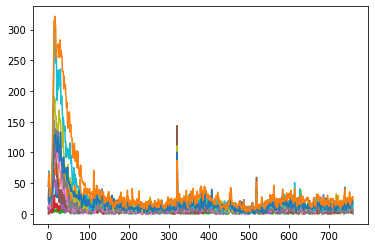

In [8]:
averages = [np.mean(i,axis=0) for i in results]
for i in averages:
    plt.plot(i)

In [ ]:
with open('ups.pickle', 'wb') as f:
    pickle.dump(averages, f)

# simple smoothing

In [ ]:
smooth = [spl.csumsmooth(i,5) for i in averages]
for i in smooth:
    plt.plot(i)

# error

In [9]:
r2 = []
for i in results:
    inner1 =[]
    for j in i:
        inner1.append(spl.csumsmooth(j,5))
    r2.append(inner1)

In [14]:
berr = spl.allstop(r2,bps,0.1)
#berr, corr = spl.allstop1(r2,bps,0.05)

In [10]:
berr2 = []
for i in range(len(r2)):
    err2 = []
    for j in range(len(r2[i])):
        err2.append(spl.newstop(r2[i][j],r2[control_index][j]))
    berr2.append(err2)

In [ ]:
t = 93
diff = r2[5][t]-r2[7][t]
ddx = np.abs(np.array(diff[1:])-np.array(diff[:-1]))
ddx = spl.triangle(spl.triangle(spl.triangle(ddx)))
plt.plot(spl.triangle(ddx), linestyle='--')
#plt.plot(r2[5][t])
#plt.plot(r2[7][t])
plt.hlines(0.05*np.max(ddx),0,70)
#np.where(ddx<0.05*np.max(ddx))[0][0]
np.where(ddx[5:] < 0.05*np.max(spl.triangle(ddx)))[0][0]

In [ ]:
#correction = [i*100 for i in corr]

#beddf.iloc[:,1] += correction[:]
#beddf.iloc[469:,2] -= correction[469:]

#beddf.to_csv('corr_mb.bed', header=False, index=False, sep= "\t")

# res and vis

In [15]:
stdbin=[]
for i in berr:
    print(np.mean(i), np.std(i))
    stdbin.append(np.std(i))

33.07142857142857 55.827388250853765
40.705357142857146 56.17340897669399
120.19642857142857 163.46139630653778
80.13988095238095 137.24233894824815
63.767857142857146 116.67167369600563
50.19642857142857 94.46549249836781
44.413690476190474 74.1700406607579
44.848214285714285 71.8384691622332
41.62797619047619 40.860116229462044
44.44940476190476 30.97815762187435
40.99107142857143 47.180598224821615
58.19047619047619 30.658342370651738


In [16]:
for i in [2,3,4,5]:
    print(spd(CI)[i], "\t", spd(stdbin)[i])

NameError: name 'CI' is not defined

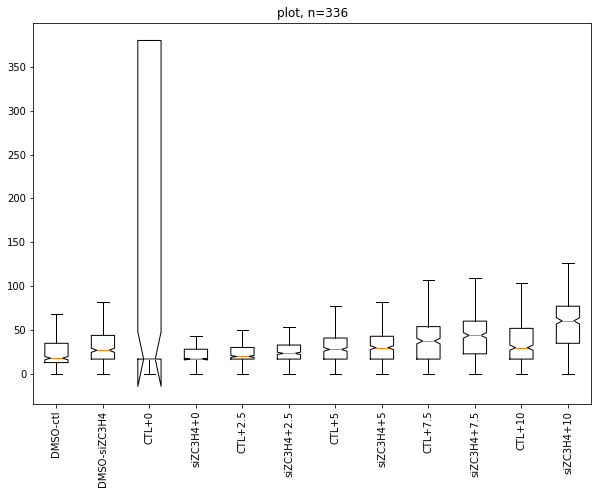

In [17]:
fig = plt.figure(figsize=(10,7))
#yt = [i*10 for i in range(10)]
plt.boxplot(berr[:], showfliers=False, notch=True)
plt.xticks(list(range(1,13)),labels, rotation=90)
#plt.ylim([0,bps])
#plt.yticks([i for i in yt],yt)
plt.title("plot, n={0}".format(len(regionlist)))
fig.patch.set_facecolor('white')
plt.show()

In [ ]:
with open('berr_ups10k.pickle', 'wb') as f:
    pickle.dump(berr,f)

In [ ]:
#want to find the speed in last 10 mins
uh = []
uh.append((np.array(berr[5]) - np.array(berr[3]))/10)
uh.append((np.array(berr[4]) - np.array(berr[2]))/10)
plt.boxplot(uh[:],showfliers=False)
plt.show()

# processivity

In [ ]:
len(relevant_juncs)

# ALL SPLICING ACTIVITY THAT COULD HAVE POSSIBLY OCCURED IN 20 MIN (I.E. APPROX 70 KB FROM TSS)

In [ ]:
indiv = list(zip(regionlist, r2[control_index], r2[6], berr2[6],berr[5]))

In [ ]:
fig = plt.figure(figsize=(20,20))
start = 0
for i in range(start,start+25):
    plt.subplot(5,5,i+1-start)
    #plt.xticks([])
    diff = indiv[i][1]-indiv[i][2]
    ddx = np.abs(np.array(diff[1:])-np.array(diff[:-1]))
    #plt.plot(diff, linestyle='--')
    env = np.max(diff)*np.exp(0.05*np.linspace(0,-71,71))
    plt.grid(False)
    plt.plot(env)
    plt.plot(np.array(diff)*np.exp(0.05*np.linspace(0,-71,71)))
    #plt.ylim([0,10])
    #plt.plot(spl.csumsmooth(indiv[i][1],5))
    #plt.plot(spl.csumsmooth(indiv[i][2],5))
    plt.hlines(0.05*np.max(diff),0,bps,colors='green', linestyle='--')
    plt.vlines(indiv[i][4],0,np.max(indiv[i][1]),colors='green', linestyle='--')
    plt.xlabel("{0}   {1}   {2}".format(regionlist[i],indiv[i][3],indiv[i][4]))
fig.patch.set_facecolor('white')
#plt.savefig('4GM1.png')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,20))
start = 50
for i in range(start,start+25):
    plt.subplot(5,5,i+1-start)
    #plt.xticks([])
    diff = indiv[i][1]-indiv[i][2]
    ddx = np.abs(np.array(diff[1:])-np.array(diff[:-1]))
    #plt.plot(diff, linestyle='--')
    env = np.linspace(np.max(diff),0,71)
    plt.grid(False)
    #plt.plot(env)
    #plt.plot(np.array(diff)*np.linspace(1,0,71))
    #plt.ylim([0,10])
    plt.plot(indiv[i][1])
    plt.plot(indiv[i][2])
    #plt.hlines(0.05*np.max(diff),0,bps,colors='green', linestyle='--')
    plt.vlines(indiv[i][3],0,np.max(indiv[i][1]),colors='green', linestyle='--')
    plt.xlabel("{0}   {1}   {2}".format(regionlist[i],indiv[i][3],indiv[i][4]))
fig.patch.set_facecolor('white')
#plt.savefig('4GM1.png')
plt.show()

In [ ]:
#let us start by appending the siCtl + 20 min to beddf
number = 4
#number = [0,350,450,600,1000]
beddf[6] = berr[5]

#beddf = beddf[beddf[6]!=bps/2]

beddf[7] = pd.qcut(beddf[6],number,labels=False)
bins = pd.qcut(beddf[6],number,retbins=True)
split = [beddf[beddf[7]==i] for i in range(number)]

In [ ]:
fig = plt.figure(figsize=(10,7))
plt.boxplot([i[6] for i in split],showfliers=False,notch=True)
plt.xlabel('"Window" of speed')
plt.ylabel('Distance travelled (kb)')
plt.ylim([0,bps])
plt.yticks([i*10 for i in yt],yt)
plt.xticks([1,2,3,4], lab, rotation=0)
fig.patch.set_facecolor('white')
plt.savefig('windows.png')

In [ ]:
lab = []
for i in range(len(bins[-1])-1):
    lab.append("{0:.2f}-{1:.2f}kb/min".format(bins[-1][i]/200,bins[-1][i+1]/200))

In [ ]:
bins[-1][:]

In [ ]:
for i in split:
    print(len(i))

In [ ]:
rawseqs = [spl.getfastas(i) for i in split]

In [ ]:
for i in range(len(rawseqs)):
    tmp = []
    for j in range(len(rawseqs[i])):
        if(split[i].iloc[j,5]=="+"):
            allcontent = sum(spl.one_hot_encode(rawseqs[i][j].seq[:300]))
            GC_content = (allcontent[1]+allcontent[2])/len(rawseqs[i][j].seq[:300])
        else:
            allcontent = sum(spl.one_hot_encode(rawseqs[i][j].antisense[:300]))
            GC_content = (allcontent[1]+allcontent[2])/len(rawseqs[i][j].antisense[:300])
        tmp.append(GC_content)
    split[i][8] = tmp

In [ ]:
with open('splitgc_flipped.pickle', 'wb') as f:
    pickle.dump(split,f)

In [ ]:
fig = plt.figure(figsize=(10,7))
#plt.boxplot([i[8] for i in split],showfliers=False,notch=True)
plt.violinplot([i[8] for i in split], showmeans=True, showextrema=False)
plt.ylabel('GC content in the first 300nt')
plt.xlabel('"Windows" of Pol II speed')
plt.ylim([0,1])
plt.xticks([1,2,3,4], ["n = {0}".format(len(i)) for i in split])
fig.patch.set_facecolor('white')
plt.savefig('GC_content_viol.png')
#plt.show()

In [ ]:
from scipy.stats import ttest_ind

for i in range(len(split)-1):
    print(ttest_ind(split[i][8],split[i+1][8]))
    
print()
print(ttest_ind(split[-1][8],split[0][8]))
print(ttest_ind(split[-2][8],split[0][8]))

# hmm

In [ ]:
with open('d2u.pickle', 'rb') as f:
    d2u = pickle.load(f)
with open('ups.pickle', 'rb') as f:
    ups = pickle.load(f)

In [ ]:
ups1 = [i[::-1] for i in ups]
upsran = list(range(-760,0))
upsyt = []
d2uyt = []

In [ ]:
fig, axs = plt.subplots(6, 1, sharex=True, gridspec_kw={'hspace': 0}, figsize=[6,7.5], sharey=True)
axs[0].plot(d2u[2])
axs[0].plot(ups[2])
axs[0].fill_between(np.arange(0,760), d2u[2], alpha=0.5, label='Sense coding gene')
axs[0].fill_between(np.arange(0,760), ups[2], alpha=0.5, label='PROMPTs')
#axs[0].text(170, 0.3, '0 min')
axs[0].legend(loc='upper left')

axs[1].plot(d2u[3])
axs[1].plot(ups[3])
axs[1].fill_between(np.arange(0,760), d2u[3], alpha=0.5)
axs[1].fill_between(np.arange(0,760), ups[3], alpha=0.5)

axs[2].plot(d2u[6])
axs[2].plot(ups[6])
axs[2].fill_between(np.arange(0,760), d2u[6], alpha=0.5)
axs[2].fill_between(np.arange(0,760), ups[6], alpha=0.5)
#axs[1].text(170, 0.3, '5 min')

axs[3].plot(d2u[7])
axs[3].plot(ups[7])
axs[3].fill_between(np.arange(0,760), d2u[7], alpha=0.5)
axs[3].fill_between(np.arange(0,760), ups[7], alpha=0.5)
#axs[2].text(170, 0.3, '10 min')

axs[4].plot(d2u[10])
axs[4].plot(ups[10])
axs[4].fill_between(np.arange(0,760), d2u[10], alpha=0.5)
axs[4].fill_between(np.arange(0,760), ups[10], alpha=0.5)

axs[5].plot(d2u[11]*0.75)
axs[5].plot(ups[11])
axs[5].fill_between(np.arange(0,760), d2u[11]*0.75, alpha=0.5)
axs[5].fill_between(np.arange(0,760), ups[11], alpha=0.5)

#fig.suptitle('RNAP II elongation rate in Genes vs PROMPTs', x=0.5, y=0.92)
#fig.text(0.03, 0.5, 'Normalised Read Density', va='center', rotation='vertical')
plt.xlabel('Kilobases from TSS')
plt.xlim([0, 200])
plt.xticks([0,50,100,150,200], [0,5,10,15,20])
plt.show()

In [ ]:
fig, axs = plt.subplots(12, 1, sharex=True, gridspec_kw={'hspace': 0}, figsize=[5.78,10], sharey=False)
axs[0].plot(d2u[2], color='red')
axs[0].fill_between(np.arange(0,760), d2u[2], alpha=1, label='Sense coding gene', color='red')
axs[0].set_ylim([0,30])
axs[0].set_yticks(d2uyt)

axs[1].plot(upsran,ups1[2], color='red')
axs[1].fill_between(upsran, ups1[2], alpha=1, label='PROMPTs', color='red')
axs[1].set_ylim([0,13])
axs[1].set_yticks(upsyt)

axs[2].plot(d2u[3], color='red')
axs[2].fill_between(np.arange(0,760), d2u[3], alpha=1, color='red')
axs[2].set_ylim([0,30])
axs[2].set_yticks(d2uyt)

axs[3].plot(upsran,ups1[3], color='red')
axs[3].fill_between(upsran, ups1[3], alpha=1, color='red')
axs[3].set_ylim([0,13])
axs[3].set_yticks(upsyt)

axs[4].plot(d2u[6], color='limegreen')
axs[4].fill_between(np.arange(0,760), d2u[6], alpha=1, color='limegreen')
axs[4].set_ylim([0,30])
axs[4].set_yticks(d2uyt)

axs[5].plot(upsran,ups1[6], color='limegreen')
axs[5].fill_between(upsran, ups1[6], alpha=1, color='limegreen')
axs[5].set_ylim([0,13])
axs[5].set_yticks(upsyt)

axs[6].plot(d2u[7], color='limegreen')
axs[6].fill_between(np.arange(0,760), d2u[7], alpha=1, color='limegreen')
axs[6].set_ylim([0,30])
axs[6].set_yticks(d2uyt)

axs[7].plot(upsran,ups1[7], color='limegreen')
axs[7].fill_between(upsran, ups1[7], alpha=1, color='limegreen')
axs[7].set_ylim([0,13])
axs[7].set_yticks(upsyt)

axs[8].plot(d2u[10], color='darkcyan')
axs[8].fill_between(np.arange(0,760), d2u[10], alpha=1, color='darkcyan')
axs[8].set_ylim([0,30])
axs[8].set_yticks(d2uyt)

axs[9].plot(upsran,ups1[10], color='darkcyan')
axs[9].fill_between(upsran, ups1[10], alpha=1, color='darkcyan')
axs[9].set_ylim([0,13])
axs[9].set_yticks(upsyt)

axs[10].plot(d2u[11]*0.65, color='darkcyan')
axs[10].fill_between(np.arange(0,760), d2u[11]*0.65, alpha=1, color='darkcyan')
axs[10].set_ylim([0,30])
axs[10].set_yticks(d2uyt)

axs[11].plot(upsran,ups1[11], color='darkcyan')
axs[11].fill_between(upsran, ups1[11], alpha=1, color='darkcyan')
axs[11].set_ylim([0,13])
axs[11].set_yticks(upsyt)

#fig.suptitle('RNAP II elongation rate in Genes vs PROMPTs', x=0.5, y=0.92)
#fig.text(0.03, 0.5, 'Normalised Read Density', va='center', rotation='vertical')
#plt.xlabel('Kilobases from TSS')
plt.xlim([-130, 200])
#plt.xticks([-100,-50,0,50,100,150,200], [-10,-5,0,5,10,15,20])
plt.xticks([])
plt.show()
with PdfPages('foo.pdf') as pdf:
    pdf.savefig(fig)